In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, GRU, ReLU
# from tensorflow.keras.callbacks import TensorBoard
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import random
import collections
import pandas as pd
import sys
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Function for ploting HISTORY of model  
def summarize_diagnostics(histories):
    plt.rcParams['figure.figsize'] = [10,10] # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories.history['loss'], color='blue', label='train')
    plt.plot(histories.history['val_loss'], color='orange', label='val')
    plt.legend(loc="upper right", fontsize=16)

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories.history['accuracy'], color='blue', label='train')
    plt.plot(histories.history['val_accuracy'], color='orange', label='val')
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

In [9]:
DATA_PATH = os.path.join(r'D:\NCKH\tempo\yolov5\vids\clone')
levels = np.array(["Feature_1", "Feature_2", "Feature_3", "Feature_4", "Feature_5"])
label_map = {label:num for num, label in enumerate(levels)}

reduce_p = 1
# Read data
sequences, labels = [], []
for level in levels:
    no_sequences = os.listdir(os.path.join(DATA_PATH, level))
    for sequence in no_sequences:
        window = []
        num = int(len(os.listdir(os.path.join(DATA_PATH, level, sequence)))*0.5)
        if num==75:
            for frame_num in range(num):
                res = np.load(os.path.join(DATA_PATH, level, sequence, "{}.npy".format(frame_num)))
                # Reduce frames
                # res = np.array([res[i] for i in range(0, len(res), reduce_p)])

                window.extend(res)
            window = np.array(window)
            sequences.append(window)
            labels.append(label_map[level])
X = np.array(sequences)

# Split data into train - test set
X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2)

# Transform data
num_pipeline = StandardScaler()
X_train = num_pipeline.fit_transform(np.array(X_train))
X_test = num_pipeline.transform(np.array(X_test))

# Balance data (Synthetic Minority Over Sampling Technique)
sm = SMOTE(sampling_strategy = 'auto' , k_neighbors = 5, random_state = 1)   
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

# Form and one-hot label for data

frame_p_obj = 75

X_train = X_train.reshape(len(X_train), frame_p_obj, 14)
y_train = to_categorical(y_train).astype(int)
X_test = X_test.reshape(len(X_test), frame_p_obj, 14)
y_test = to_categorical(y_test).astype(int)

In [10]:
X_train.shape

(775, 75, 14)

Train X shape: (775, 75, 14)
Train y shape(775, 5)

Test X shape: (168, 75, 14)
Test y shape(168, 5)


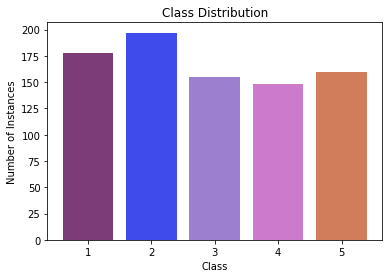

In [11]:
print(f'Train X shape: {X_train.shape}\nTrain y shape{y_train.shape}\n')
print(f'Test X shape: {X_test.shape}\nTest y shape{y_test.shape}')

# Plot distribution of whole data
colors = []
for i in range(10):
    colors.append((random.random(), random.random(), random.random()))
dicc = dict()
for i, j in zip(pd.DataFrame(labels).value_counts(), pd.DataFrame(labels).value_counts().index):
  dicc[int(j[0]) + 1] = i
od = collections.OrderedDict(sorted(dicc.items()))
plt.bar(od.keys(), od.values(), color=colors)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.xticks(list(od.keys()))
plt.ylabel("Number of Instances")
plt.show()

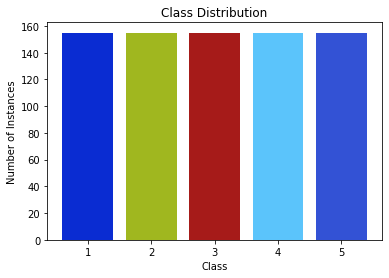

In [13]:
# Plot distribution of train
categorical_labels = np.argmax(y_train, axis=1)
categorical_labels

colors = []
for i in range(10):
    colors.append((random.random(), random.random(), random.random()))
dicc = dict()
for i, j in zip(pd.DataFrame(categorical_labels).value_counts(), pd.DataFrame(categorical_labels).value_counts().index):
  dicc[int(j[0]) + 1] = i
od = collections.OrderedDict(sorted(dicc.items()))
plt.bar(od.keys(), od.values(), color=colors)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.xticks(list(od.keys()))
plt.ylabel("Number of Instances")
plt.show()

In [14]:
from keras.callbacks import EarlyStopping
from keras import metrics
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import math


def step_decay(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

# def step_decay(epoch):
#     initial_lrate = 0.01
#     drop = 0.5
#     epochs_drop = 10
#     lrate = initial_lrate * math.pow(drop, 
#               math.floor((1+epoch)/epochs_drop))
#     return lrate




# early_stopping_monitor = EarlyStopping(patience=5)

# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)
d = 0.01
_, v1, v2 = X_train.shape

# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(v1, v2)))
# # model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(levels.shape[0], activation='softmax'))

# model.add(LSTM(64, input_shape=(v1, v2)))
# model.add(BatchNormalization())
# model.add(Dense(levels.shape[0]))

# Định nghĩa các callbacks để sử dụng trong quá trình huấn luyện
learning_rate_schedule = LearningRateScheduler(step_decay)

callbacks_list = [learning_rate_schedule]


#-------------  loss: 0.1279 - accuracy: 0.9497 - val_loss: 0.4016 - val_accuracy: 0.8988
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)
adam = Adam(lr=0.01)
model = Sequential()
model.add(LSTM(64, input_shape=(v1, v2), return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(levels.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000, validation_data=(X_test, y_test)
#                     , callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=20), learning_rate_schedule])

history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000, validation_split=0.33, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=20), learning_rate_schedule])


#-------------  loss: 0.0895 - accuracy: 0.9686 - val_loss: 0.3550 - val_accuracy: 0.8690
# model = Sequential()
# model.add(LSTM(64, input_shape=(v1, v2),  return_sequences=True))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(32, activation='elu'))
# model.add(Dense(levels.shape[0], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000, validation_data=(X_test, y_test)
#                     , callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=15)])


#-------------  
# model = Sequential()
# model.add(GRU(64, input_shape=(v1, v2), return_sequences=False))
# model.add(BatchNormalization())
# model.add(Dense(levels.shape[0], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000, validation_data=(X_test, y_test)
#                     , callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=15)])





Epoch 1/1000
5/5 [==============================] - 3s 170ms/step - loss: 2.0522 - accuracy: 0.1541 - val_loss: 1.4822 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 2/1000
5/5 [==============================] - 0s 58ms/step - loss: 1.3308 - accuracy: 0.4566 - val_loss: 1.3511 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 3/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.1191 - accuracy: 0.5414 - val_loss: 1.2590 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 4/1000
5/5 [==============================] - 0s 58ms/step - loss: 0.9701 - accuracy: 0.5780 - val_loss: 1.2029 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 5/1000
5/5 [==============================] - 0s 58ms/step - loss: 0.8682 - accuracy: 0.6262 - val_loss: 1.1636 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 6/1000
5/5 [==============================] - 0s 59ms/step - loss: 0.8012 - accuracy: 0.6609 - val_loss: 1.1277 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 7/1000
5/5 [==============================] - 0s 59ms/step - loss: 0.

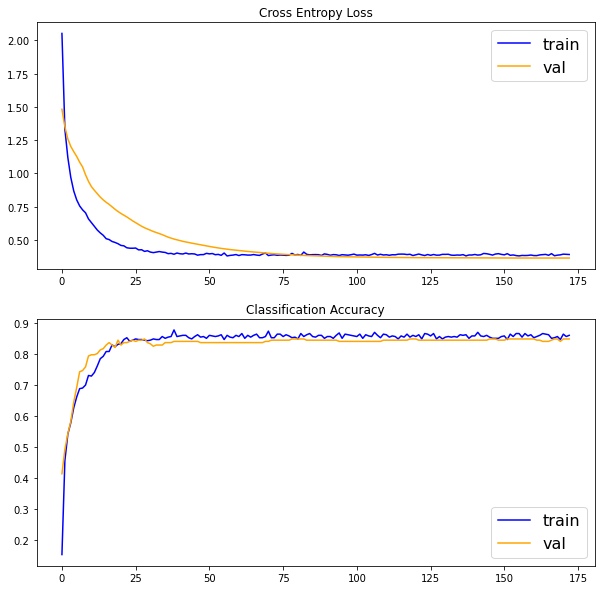

In [15]:
summarize_diagnostics(history)
# summarize_diagnostics(cbam)


In [16]:
model.save('acc_85_75_frames.h5')
import joblib
joblib.dump(num_pipeline, 'lstm_scaler_2.bin', compress=True)

['lstm_scaler_2.bin']

In [124]:
a = X_train.copy()
print(a.shape)

(795, 150, 14)


In [ ]:
# from keras.models import Model
# from keras.layers import Input, LSTM, Dense, TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.pooling import GlobalAveragePooling1D
# from keras.layers.merge import concatenate

# def cbam_model(input_shape=(100, 1)):
#   d = 0.01
#   input_layer = Input(shape=input_shape)

#   # Add Conv1D layer for feature extraction
#   conv1d_layer = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_layer)

#   # Apply Spatial Attention mechanism
#   avg_pooling_layer = GlobalAveragePooling1D()(conv1d_layer)
#   dense_layer1 = Dense(units=32, activation='relu')(avg_pooling_layer)

#   dense_layer1 = Dropout(d)(dense_layer1)


#   dense_layer2 = Dense(units=32, activation='relu')(dense_layer1)

#   dense_layer2 = Dropout(d)(dense_layer2)

#   add_layer1 = dense_layer1 + dense_layer2
#   spatial_attention_layer = Dense(units=1, activation='sigmoid', name='spatial_attention')(add_layer1)
#   spatial_attention_layer = Dropout(d)(spatial_attention_layer)

#   # Apply Channel Attention mechanism
#   lambda_layer = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=2))(conv1d_layer)
#   dense_layer3 = Dense(units=32, activation='relu')(lambda_layer)
#   dense_layer4 = Dense(units=32, activation='relu')(dense_layer3)
#   add_layer2 = dense_layer3 + dense_layer4
#   channel_attention_layer = Dense(units=32, activation='sigmoid', name='channel_attention')(add_layer2)

#   # Combine Spatial and Channel Attention mechanisms
#   multiply_layer = keras.layers.multiply([conv1d_layer, spatial_attention_layer, channel_attention_layer])

#   # Add LSTM layers
#   lstm_layer1 = LSTM(units=64, return_sequences=True)(multiply_layer)
#   lstm_layer2 = LSTM(units=64)(lstm_layer1)

#   # Add output layer
#   output_layer = Dense(levels.shape[0], activation='softmax')(lstm_layer2)

#   model = Model(inputs=[input_layer], outputs=output_layer)
#   return model

# # Compile the model
# cbam_lstm_model = cbam_model(input_shape=(v1, v2))
# cbam_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# cbam = cbam_lstm_model.fit(X_train, y_train, batch_size = 200, epochs = 1000, validation_data=(X_test, y_test),
#                            callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=20)])

In [118]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from keras.models import load_model

model = load_model('acc_89.h5')

# yhat = model.predict([X_test[0]])
yhat = model.predict(X_test[0].reshape(1, frame_p_obj, 14))
print(yhat.shape)
ytrue = np.argmax(y_test[0]).tolist()
yhat = np.argmax(yhat).tolist()
print(ytrue, yhat)
# print(multilabel_confusion_matrix(ytrue, yhat))
# print(f'ACCURACY: {accuracy_score(ytrue, yhat)}')

(1, 5)
1 1


In [11]:
import numpy as np
a = np.array(range(150))
b = np.array([a[i] for i in range(0, len(a), 3)])
# print(len(a))
print(len(b))
b

50


array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147])

In [3]:
np.load(r'D:\NCKH\tempo\yolov5\vids\orin_cut_vids\Feature_1\0\0.npy')

array([0.00000000e+00, 2.46000000e+02, 1.23453081e+00, 1.34823883e+02,
       1.35080322e+02, 2.12483406e+00, 3.79292000e+05, 5.39857623e+00,
       5.99924111e-01, 7.81332078e-01, 5.82486734e-01, 5.77012208e+02,
       3.39290796e-01, 6.48576822e-04])